# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymystem3 import Mystem
m = Mystem()
from collections import Counter

In [6]:
data = pd.read_csv('/datasets/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [7]:
# получение первых 10 строк таблицы
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [8]:
#проверка названия колонок
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

**Вывод**
- В таблице 12 колонок и 21525 строк
- Среди типов бъектов встречаются строки, целые числа и дробные
- В столбцах `days_employed` и `total_income` встречаются пропуски

##  Предобработка данных

### Обработка пропусков

In [9]:
# подсчёт пропущенных значений
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Не все пропущенные значения влияют на исследование. Так в `days_employed` и `total_income` пропуски не важны для этой работы и точностью значений в них можно пренебречь. Так как в этих столбцах тип данных `float`, то и пропуски нужно заменять соответсвующим типом данных.


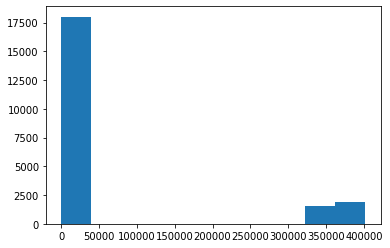

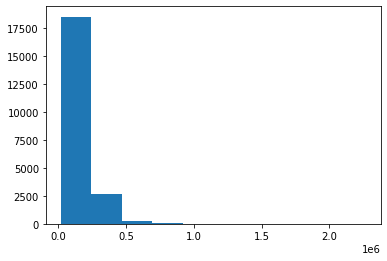

In [42]:
#проверим расброс значений, чтобы определить, есть ли в данных аномалии или выбросы
plt.hist(data['days_employed'])
plt.show()
plt.hist(data['total_income']);

В данных большие выбросы. Скорее всего это связано с технической ошибкой при выгрузке данных. По этой же причне, скорее всего, присутсвуют и так много пропусков.Мало вероятно, что в базе данных банка пропуски не заполнили специально или забыли заполнить. Из-за большого расброса значений целесообразнее заполнить пропуски медианным значением. Также, учитавая, что `days_employed` — общий трудовой стаж в днях, a `total_income` — ежемесячный доход, то значения в них не могут быть отрицательными. Исправим это с помощью метода `abs`

In [11]:
# перебор названий столбцов в цикле и замена пропущенных значений на медианное
try:
    columns_to_replace = ['days_employed', 'total_income']
    for i in columns_to_replace:
        data[i] = np.abs(data[i])
        data[i] = data[i].fillna(data[i].sort_values().median())
except:
    print('В пропусках есть нечисловые значения')

In [12]:
#проверим важный для нас столбец `children`
data['children'].sort_values().unique()

array([-1,  0,  1,  2,  3,  4,  5, 20])

In [13]:
#посмотрим строки, где по технической ошибке количество детей равно -1
data[data['children'] == -1].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,2194.220567,57,Среднее,1,женат / замужем,0,F,пенсионер,0,145017.937533,на покупку своего автомобиля


In [14]:
#посчитаем строки, где количество детей равно 20
data[data['children'] == 20].count()

children            76
days_employed       76
dob_years           76
education           76
education_id        76
family_status       76
family_status_id    76
gender              76
income_type         76
debt                76
total_income        76
purpose             76
dtype: int64

Вряд ли, среди заемщиков присутсвует 76 человек, у которых 20 детей. Такое было бы возможным, если бы это был один человек, но не 76. Скорее всего, это либо случайная опечатка, и вместо 2, написали 20, либо техническая ошибка при выгрузке как и (-1)

In [15]:
#изменим неверные значения -1 и 20 в столбце 'children' на 1 и 2 соответственно
data['children'] = data['children'].replace(-1, 1)
data['children'] = data['children'].replace(20, 2)

In [16]:
#перепроверим уникальные значения столбца `children`
data['children'].sort_values().unique()

array([0, 1, 2, 3, 4, 5])

In [17]:
#провереряем, не осталось ли пропусков
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Учитывая, что это это данные из банковских анкет, вряд ли данные, которые были пропущены, не были внесены самими заемщиками. Скорее всего эти данные либо упустили при составлении таблицы, либо это техническая ошибка при выгрузке базы. Если бы это был не учебный кейс, то следовало бы связаться с человеком, проводившим выгрузку данных и сообщить ему об ошибках и попытаться их исправить. Но в учебном задание такое невозможно, поэтому приходится работать с тем, что есть. Для данного анализа нам важна взаимосязь с количеством детей и семейным положением, поэтому пропущенными значениями в столбцах с общим трудовым стажем `days_employed` и ежемесячным доходом`total_income` мы пожем пренебречь. Они не повлияют на итоговое решение. Учитывая большой выброс в данных, применили фунцию `median()` для подстановки медианного значения, вместо пропущенных. Так же заменили значения с столбце `children` с *-1* на *1* и с *20* на *2*, потому что они оказались неправдоподобными.

### Замена типа данных

In [18]:
#заменяю тип 'float' на 'int' в столбце 'days_employed'
try:
    data['days_employed'] = data['days_employed'].astype('int')
except:
    print('В столбце есть нечисловые значения')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  int64  
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Вывод**

Учитывая, что общий трудовой стаж в днях, не может быть вещественным числом, то я привёл тип данных в столбце `days_employed` к типу данных `int`. Конечно, многие значения выглядят неправдаподобными, но раз они не влияют на результат нашего анализа, то просто оставим их в том виде, к которому привели.

### Обработка дубликатов

Мы хотим убрать из таблицы людей, которые из-за какой-то ошибки попали в нашу таблицу дважды. По-хорошему, чтобы отличать людей нам нужны их id. Тогда мы сможем со 100% вероятностью говорить, что люди с разными id - это разные люди. Здесь у нас id нет. Но посмотрев на столбцы, мы можем сделать вывод, что событие, когда 2 человека полностью одинаковые по всем столбцам, являются разными людьми, крайне маловероятно. Поэтому можем считать, что если значения во всех столбцах совпадают, значит это один и тот же человек, а мы не хотим допускать такого и поэтому удаляем дубликаты.

In [19]:
#напишем функцию для приведения всез знчений с типом `object` к нижнему регистру
def lowering(table):
    for i in ['education', 'family_status', 'gender', 'income_type', 'purpose']:
        table[i] = table[i].str.lower()
    return table

lowering(data)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628.550329,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,f,компаньон,0,224791.862382,операции с жильем
21521,0,343937,67,среднее,1,женат / замужем,0,f,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113,38,среднее,1,гражданский брак,1,m,сотрудник,1,89672.561153,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,m,сотрудник,1,244093.050500,на покупку своего автомобиля


In [20]:
#поиск и удаление явных дубликатов
display(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
display(data.duplicated().sum())
data.info()

71

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21454 non-null  int64  
 1   days_employed     21454 non-null  int64  
 2   dob_years         21454 non-null  int64  
 3   education         21454 non-null  object 
 4   education_id      21454 non-null  int64  
 5   family_status     21454 non-null  object 
 6   family_status_id  21454 non-null  int64  
 7   gender            21454 non-null  object 
 8   income_type       21454 non-null  object 
 9   debt              21454 non-null  int64  
 10  total_income      21454 non-null  float64
 11  purpose           21454 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


In [21]:
#напишем функцию для поиска неявных дубликатов
def double(table, column):
    table[column].sort_values().unique()
    print(f"В столбце '{column}' {len(table[column].sort_values().unique())} уникальных значений: {table[column].sort_values().unique()}")
    return

for i in ['education', 'family_status', 'gender', 'income_type', 'purpose']:
    double(data, i)

В столбце 'education' 5 уникальных значений: ['высшее' 'начальное' 'неоконченное высшее' 'среднее' 'ученая степень']
В столбце 'family_status' 5 уникальных значений: ['в разводе' 'вдовец / вдова' 'гражданский брак' 'женат / замужем'
 'не женат / не замужем']
В столбце 'gender' 3 уникальных значений: ['f' 'm' 'xna']
В столбце 'income_type' 8 уникальных значений: ['безработный' 'в декрете' 'госслужащий' 'компаньон' 'пенсионер'
 'предприниматель' 'сотрудник' 'студент']
В столбце 'purpose' 38 уникальных значений: ['автомобили' 'автомобиль' 'высшее образование'
 'дополнительное образование' 'жилье' 'заняться высшим образованием'
 'заняться образованием' 'на покупку автомобиля'
 'на покупку подержанного автомобиля' 'на покупку своего автомобиля'
 'на проведение свадьбы' 'недвижимость' 'образование' 'операции с жильем'
 'операции с коммерческой недвижимостью' 'операции с недвижимостью'
 'операции со своей недвижимостью' 'покупка жилой недвижимости'
 'покупка жилья' 'покупка жилья для сдачи' '

In [22]:
#проверим строку, где пол обозначен как xna
data[data['gender'] == 'xna']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10684,0,2358,24,неоконченное высшее,2,гражданский брак,1,xna,компаньон,0,203905.157261,покупка недвижимости


Опять же учитывая, что для конкретного анализа нам не важен пол, то пусть это будет девушка с неоконченным высшим образованием, занимающаяся бизнесом

In [23]:
data['gender'] = data['gender'].replace('xna', 'f')
double(data, 'gender')

В столбце 'gender' 2 уникальных значений: ['f' 'm']


**Вывод**

В результате поиска дубликатов было найдено 71 повторяющихся строк, которые в последствии были удалены. В итоге стало 21454 вместо 21525 строк. Так же заменил значение неизвестного пола `xna` на `f`. Дубликаты вероятно появились изза технической ошибки при выгрузке базы

### Лемматизация

Чтобы распределить цели получения кредита по категориям составим леммы целей

In [24]:
#посмотрим леммы на основе столбца 'purpose' и посчитаем их
lemmas = m.lemmatize(' '.join(data['purpose']))
Counter(lemmas).most_common()


[(' ', 55023),
 ('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('подержать', 853),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('приобретение', 461),
 ('профильный', 436),
 ('подержанный', 111),
 ('\n', 1)]

**Вывод**

В столбце `purpose` много значений повторяются в видоизменённой форме. Скорее всего, это вызвано тем, что заемщики сами указывали цель кредита, а не выбирали из списка. Следовало бы сделать категоризацию, для более точного анализа.

### Категоризация данных

Разобьём заемщиков на 4 категории по целям кредита: `недвижимость`, `автомобиль`, `образование`, `свадьба`. За основу категорий взял полученные леммы

In [25]:
#напишем функцию для создания категорий по столбцу 'purpose'
def purpose_type(a):
    b = m.lemmatize(a)
    if 'ремонт' in b:
        return 'ремонт'
    if ('жилье' in b) or ('недвижимость' in b):
        return 'недвижимость'
    if 'автомобиль' in b:
        return 'автомобиль'
    if 'образование' in b:
        return 'образование'
    if 'свадьба' in b:
        return 'свадьба'
    return 'unknown'  

In [26]:
# создадим столбец 'purpose_type' с категориями целей кредита с помощью метода apply()
try:
    data['purpose_type'] = data['purpose'].apply(purpose_type)
except:
    print('ERROR')
# посчитаем количество значений каждой категории
data['purpose_type'].value_counts()

недвижимость    10204
автомобиль       4306
образование      4013
свадьба          2324
ремонт            607
Name: purpose_type, dtype: int64

Узнаем минимальное, максимальное и медианное знаечие в даходах заемщиков

In [27]:
display(data['total_income'].min())
display(data['total_income'].max())
display(data['total_income'].median())

20667.26379327158

2265604.028722744

145017.93753253992

Так как в данных таблицы очень болшой разброс в доходах делить на `средний класс`, `ниже среднего` и `выше среднего` нецелесообразно.
Разделим заемщиков также на 5 категорий по уровню дохода:
- 20000 - 70000
- 70000 - 145000
- 145000 - 300000
- 300000 - 500000
- 500000 - 2300000

In [28]:
# напишем функцию для создания категорий по уровню дохода
def income_cat(income):
    if 20000 <= income < 70000:
        return '020_070'
    if 70000 <= income < 145000:
        return '070_145'
    if 145000 <= income < 300000:
        return '145_300'
    if 300000 <= income < 500000:
        return '300_500'
    if 500000 <= income < 23000000:
        return '500_2300'

In [29]:
# создадим столбец 'income_cat' с категориями по уровню дохода с помощью метода apply()
try:
    data['total_income_id'] = data['total_income'].apply(income_cat)
except:
    print('ERROR')

# поменяем индекс столбца для удобства восприятия
col = data.pop('total_income_id')
data.insert(11, col.name, col)

# посчитаем количество значений каждой категории
data['total_income_id'].value_counts()

145_300     10298
070_145      8200
020_070      1474
300_500      1260
500_2300      222
Name: total_income_id, dtype: int64

Учитывая, что по многим признакам заемщики делятся на 5 категорий, разделим их также на 5 категорий ко количеству детей

In [30]:
# напишем функцию для категоризации по количеству детей
def child_id(amount):
    if amount == 0:
        return '0'
    if amount == 1:
        return '1'
    if amount == 2:
        return '2'
    if amount == 3:
        return '3'
    return '4+'

# создадим столбец 'child_id'
data['child_id'] = data['children'].apply(child_id)
# поменяем индекс столбца для удобства восприятия
col = data.pop('child_id')
data.insert(1, col.name, col)

In [31]:
# категории по количеству детей  
data['child_id'].value_counts()

0     14091
1      4855
2      2128
3       330
4+       50
Name: child_id, dtype: int64

In [32]:
# категории по семейному статусу
data['family_status_id'].value_counts(sort=False)

0    12339
1     4151
2      959
3     1195
4     2810
Name: family_status_id, dtype: int64

In [33]:
# категории по уровню дохода
data['total_income_id'].value_counts(sort=False)

500_2300      222
300_500      1260
145_300     10298
070_145      8200
020_070      1474
Name: total_income_id, dtype: int64

In [34]:
# категории по цели кредита  
data['purpose_type'].value_counts(sort=False)

образование      4013
недвижимость    10204
свадьба          2324
ремонт            607
автомобиль       4306
Name: purpose_type, dtype: int64

**Вывод**

Для проведения анализа разделил заемщиков по 4 параметрам:
- количество детей
- семейный статус
- уровень доход
- цель крелита

Каждую группу разделил на 5 категорий.

## Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

,debt
child_id,
0,0.075438
1,0.091658
2,0.094925
3,0.081818
4+,0.080000


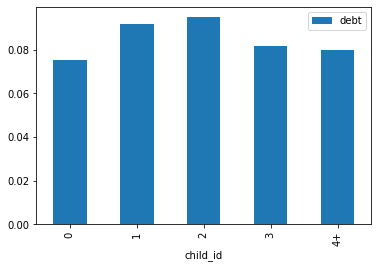

In [45]:
child_pivot = pd.pivot_table(data,
                             index=['child_id'],
                             values=['debt'])
display(child_pivot)
child_pivot.plot.bar();

**Вывод**

Стоить заменить, что клиенты без детей возвращают кредит в срок с самой большой вероятностью. Чуть меньшая вероятность у клиентов, имеющих 3 и более детей. А у клиентов с одним и двумя детьми самая большая вероятность опоздать с выплатой займа.
Скорее всего, это связано с тем, что при появлении детей, у людей появляются больше трат и больше непредвиденных проблем, из-за чего они и помог опоздать с выплатой. Но к тому моменту когда в семье более трех детей, у них уже сформиловалась какая-то система, и все трудности даются им легче, от чего и вероятность просрочки ниже.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

,debt
family_status,
в разводе,0.071130
вдовец / вдова,0.065693
гражданский брак,0.093471
женат / замужем,0.075452
не женат / не замужем,0.097509


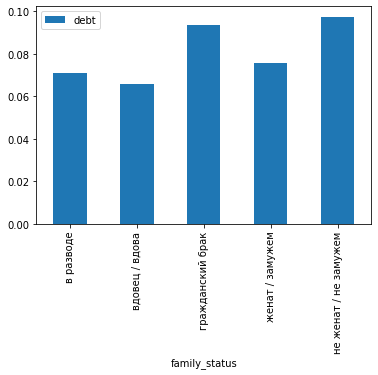

In [46]:
family_pivot = pd.pivot_table(data,
                             index=['family_status'],
                             values=['debt'])
display(family_pivot)
family_pivot.plot.bar();

**Вывод**

Так же как и с детьми, влияние семейного статуса на возврат кредита в срок не такое существенное.
Самые ответственные здесь `вдовы(цы)`, чуть более рискованные кандидатуры `женатые/замужние` и `разведенные` и самые рискованные - `живущие в гражданском браке` и `не женатые(замужние)`.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

,debt
total_income_id,
020_070,0.068521
070_145,0.085732
145_300,0.080695
300_500,0.073016
500_2300,0.063063


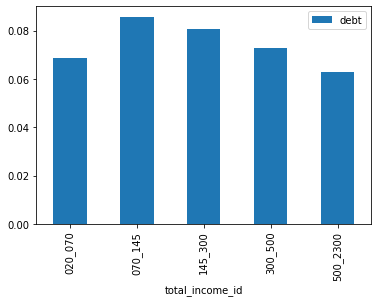

In [47]:
income_pivot = pd.pivot_table(data,
                             index=['total_income_id'],
                             values=['debt'])
display(income_pivot)
income_pivot.plot.bar();

**Вывод**

Заёмщики с доходом  20 - 70 тыс и более 500 тыс чаще всех возвращают заём в срок. Максимальная вероятность просрочки у клиентов банка с доходами 70 - 145 тыс и 145 - 300 тыс.

- Как разные цели кредита влияют на его возврат в срок?

,debt
purpose_type,
автомобиль,0.093590
недвижимость,0.073207
образование,0.092200
ремонт,0.057661
свадьба,0.080034


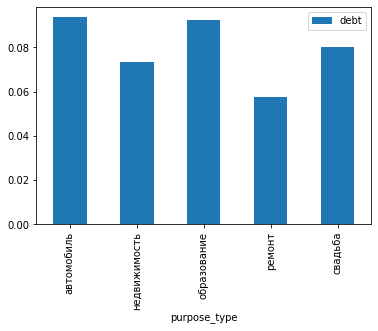

In [48]:
purpose_pivot = pd.pivot_table(data,
                             index=['purpose_type'],
                             values=['debt'])
display(purpose_pivot)
purpose_pivot.plot.bar();

**Вывод**

Самые рискованые цели получения кредита - это покупка автомобиля и получение образования. Меньше же всего риска представляют заёмщики, которые берут кредит на ремонт.

## Общий вывод

Самая большая вероятность вернуть кредит в срок:
- у клиентов без детей
- у вдов/вдовцов
- у клиентов, чей ежемесячный доход состовляет от 20 до 70 тыс и более 500 тыс рублей
- у клиентов, берущих кредит на ремонт

Самые рискованные группы:
- у клиентов с одним или двумя детьми
- у не женатых/не замужних или живущих в гражданском браке
- у клиентов, чей ежемесячный доход состовляет от 70 до 300 тыс
- у клиентов берущих кредит на покупку автомобиля или получение образования